# ✈️ Flight Delays Analysis – Exploratory Data Analysis (EDA)

This notebook is part of the **`flight-delays-analysis`** project. The goal is to analyze real-world flight delay data from the United States to uncover meaningful patterns and develop a basic predictive model.

---

## 🎯 Notebook Objectives

- Load the raw dataset
- Understand the structure and quality of the data
- Detect missing values, duplicates, and irrelevant features
- Identify initial patterns related to delays and cancellations

---

## 📁 Dataset Overview

The dataset contains flight records with variables such as:

- Airline, origin, destination
- Scheduled departure and arrival times
- Delay causes (weather, security, etc.)
- Cancellation information

Source: [Kaggle – Airline Delay Causes](https://www.kaggle.com/datasets/giovamata/airlinedelaycauses)

---

## 🧠 Notes

- This EDA focuses solely on **delay behavior**, not external economic or meteorological data.
- Key findings will be used later as a foundation for modeling and reporting.

---

📌 Author: **Josekawa** – 2025  
🔗 GitHub Repository: [github.com/Josekawa/flight-delays-analysis](https://github.com/Josekawa/flight-delays-analysis)



## 🧭 Project Workflow

To structure the analysis and keep things focused, I’m following a clear workflow that covers everything from data loading to exporting a cleaned dataset for modeling. Here's the step-by-step plan:

1. **Load the dataset**  
   Import the CSV file and confirm it loads correctly using Pandas.

2. **Initial inspection**  
   Get a general sense of the structure and contents of the dataset using `.info()`, `.describe()`, and other quick checks.

3. **Data cleaning**  
   Drop irrelevant or redundant columns, handle missing values, and create a proper `Date` column for time-based analysis.

4. **Feature documentation**  
   Record what each remaining column means, which ones are useful, and why I’ve kept them.

5. **Exploratory visuals**  
   Use charts to explore patterns in delays, cancellations, carriers, days of the week, and other relevant dimensions.

6. **Correlation analysis**  
   Compare different delay causes and examine their relationship with arrival delay using a correlation matrix.

7. **Save the cleaned dataset**  
   Export a cleaned version of the data to the `/data/processed/` folder for use in the modeling phase.



In [18]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup for visualizations
sns.set_palette('pastel')
%matplotlib inline

# 📄 Load the dataset
file_path = '../data/raw/DelayedFlights.csv'
df = pd.read_csv(file_path)

# 🔍 Quick preview
print(f"Shape of dataset: {df.shape}")
df.head()



Shape of dataset: (1936758, 30)


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [19]:
# Información general del dataset
df.info()

# Estadísticas de columnas numéricas
df.describe()

# Ver nombres de columnas
df.columns

# Ver tamaño del dataset
df.shape

# Comprobar nulos
df.isnull().sum()

# Ver duplicados
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

0

The `ArrDelay` column ranges from -89 to over 1400 minutes. Most delays seem mild, but there are extreme outliers. This might affect visualizations or model performance later if not handled properly.


## ✍️ First Impressions from the Initial Inspection

- The dataset is large — almost 2 million rows and over 30 columns. That provides a rich set of information but requires careful focus to avoid unnecessary complexity.
- Time-related columns like `DepTime` and `ArrTime` are stored as floats. This suggests potential formatting issues or missing values that may need conversion or removal.
- Several delay-related fields (`CarrierDelay`, `WeatherDelay`, etc.) may contain NaNs when no delay occurred. This is logically consistent, but I’ll need to confirm that before deciding how to treat them.
- `Cancelled` and `Diverted` are binary columns indicating whether the flight occurred as planned. These will be important for filtering later to avoid bias in the delay analysis.
- Columns like `FlightNum`, `TailNum`, and `CRSElapsedTime` may not directly help with modeling but could offer insights during EDA.
- The column `Unnamed: 0` appears to be an autogenerated index — not useful, and likely safe to drop.

Overall, the dataset looks rich and fairly well structured. With the right cleanup and filtering, it should be well suited for exploratory and predictive analysis.



## 🔧 Initial Cleanup and Date Construction

In this section, we remove columns that are not analytically useful and create a proper datetime column by combining `Year`, `Month`, and `DayofMonth`. This will simplify temporal grouping and visualization.


In [20]:
# Check if date components exist
date_cols = ['Year', 'Month', 'DayofMonth']
if all(col in df.columns for col in date_cols):
    # Build the Date column
    df['Date'] = pd.to_datetime(
        df[date_cols].rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'})
    )
    # Drop the original date parts
    df.drop(columns=date_cols, inplace=True)

# Move 'Date' to the first column if it exists
if 'Date' in df.columns:
    # Reorder columns
    cols = ['Date'] + [col for col in df.columns if col != 'Date']
    df = df[cols]

# Drop columns that do not add analytical value
columns_to_drop = [
    'Unnamed: 0', 'FlightNum', 'TailNum', 'TaxiIn', 'TaxiOut',
    'AirTime', 'DepTime', 'CRSDepTime', 'CRSArrTime',
    'ActualElapsedTime', 'CRSElapsedTime', 'Year', 'Month', 'DayofMonth'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Preview the result
df.head()



,Date,DayOfWeek,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008-01-03,4,2211.0,WN,-14.0,8.0,IAD,TPA,810,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008-01-03,4,1002.0,WN,2.0,19.0,IAD,TPA,810,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008-01-03,4,804.0,WN,14.0,8.0,IND,BWI,515,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008-01-03,4,1959.0,WN,34.0,34.0,IND,BWI,515,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008-01-03,4,2121.0,WN,11.0,25.0,IND,JAX,688,0,N,0,NaN,NaN,NaN,NaN,NaN


## 📄 Column Definitions (for reference)

Before diving deeper, I want to document what each column represents — both for myself and anyone else reading this later. I've already dropped a number of columns that were redundant, constant, or not relevant for the type of analysis I want to do (like raw timestamps, flight IDs, and distance). 

Here’s a quick overview of the key variables I’ve kept in the dataset:

- `Date`: Combined from Year, Month, and DayofMonth
- `UniqueCarrier`: Airline code
- `Origin`: Origin airport (IATA)
- `Dest`: Destination airport (IATA)
- `ArrDelay`: Arrival delay in minutes  
- `CancellationCode`: Reason (A = carrier, B = weather, C = NAS, D = security)
- `Diverted`: Whether the flight was diverted from its scheduled destination (1 = yes, 0 = no)
- `CarrierDelay`: Airline responsibility (e.g. maintenance, crew)
- `WeatherDelay`: Due to hazardous weather
- `DayOfWeek`: Numeric representation of the day of the week (1 = Monday, 7 = Sunday). Useful for identifying patterns in delays across weekdays and weekends.
- `NASDelay`: NAS-related (air traffic, runways, etc.)
- `SecurityDelay`: Security-related issues
- `LateAircraftDelay`: Caused by late arrival of aircraft from a previous flight

This list will help me stay focused on the features that matter most for EDA, modeling, and visual storytelling.


## 🧼 Handling Missing Values and Duplicates

This section identifies and removes rows with missing values in critical columns, as well as duplicate records, to ensure the integrity and quality of the dataset before analysis.


In [21]:
delay_cols = [
    'CarrierDelay', 'WeatherDelay', 'NASDelay',
    'SecurityDelay', 'LateAircraftDelay'
]
df[delay_cols] = df[delay_cols].fillna(0)

# Drop rows with any missing values
df.dropna(inplace=True)

# Drop duplicate rows
print(f"Duplicate rows before cleaning: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Duplicate rows after cleaning: {df.duplicated().sum()}")

# Keep only flights that were completed and not diverted
df = df[(df['Cancelled'] == 0) & (df['Diverted'] == 0)]

# Optional: drop the columns if you no longer need them
df.drop(columns=['Cancelled', 'Diverted'], inplace=True)

# Confirm result
print(f"Remaining flights: {len(df)}")


# Final overview
df.head()


Duplicate rows before cleaning: 2
Duplicate rows after cleaning: 0
Remaining flights: 1928369


,Date,DayOfWeek,ArrTime,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Distance,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008-01-03,4,2211.0,WN,-14.0,8.0,IAD,TPA,810,N,0.0,0.0,0.0,0.0,0.0
1,2008-01-03,4,1002.0,WN,2.0,19.0,IAD,TPA,810,N,0.0,0.0,0.0,0.0,0.0
2,2008-01-03,4,804.0,WN,14.0,8.0,IND,BWI,515,N,0.0,0.0,0.0,0.0,0.0
3,2008-01-03,4,1959.0,WN,34.0,34.0,IND,BWI,515,N,2.0,0.0,0.0,0.0,32.0
4,2008-01-03,4,2121.0,WN,11.0,25.0,IND,JAX,688,N,0.0,0.0,0.0,0.0,0.0


## 📈 Exploring the Distribution of Arrival Delays

Let’s kick off the exploratory analysis by looking at how arrival delays are distributed across all flights in the dataset. This is a crucial first step because it helps shape how we define what a “delay” really is — are we talking about 5 minutes? 50? More?

Visualizing this distribution also gives us a sense of the general shape of the data (e.g., is it skewed?), whether we’re dealing with extreme outliers, and how frequent delays actually are.

We’ll limit the x-axis a bit to focus on the range where most flights fall, and avoid the distortion caused by a few very extreme cases (some flights are delayed by hundreds of minutes, but they’re rare).


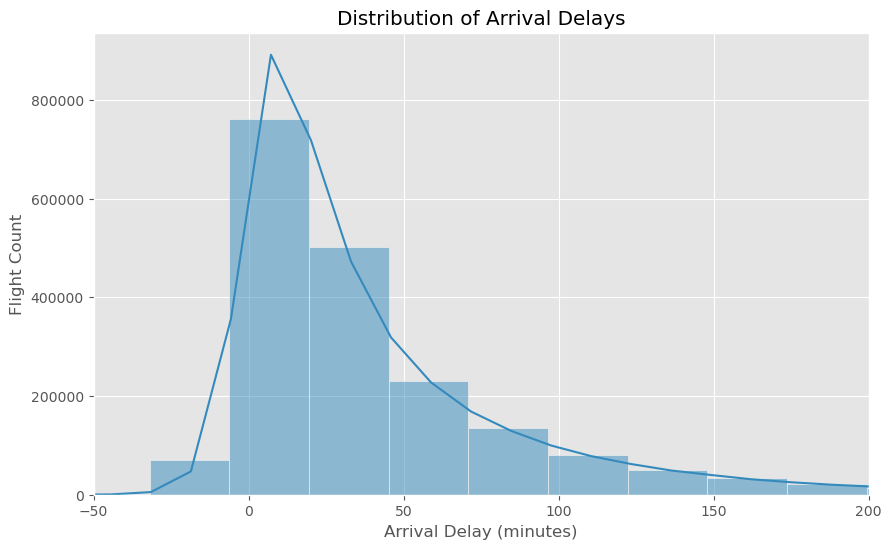

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # or 'classic', or simply remove the line entirely

plt.figure(figsize=(10, 6))
sns.histplot(df['ArrDelay'], bins=100, kde=True)
plt.xlim(-50, 200)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Flight Count')
plt.show()


### 🧠 Quick Thoughts

As expected, most flights cluster around short delays or even early arrivals, but there’s a long right tail — meaning a small number of flights experience very long delays. This kind of skewed distribution is typical in real-world operational data.

It also tells me that using the **mean** alone might be misleading. The **median** or even categorical thresholds (e.g. “on time”, “moderately delayed”, “severely delayed”) could be more useful depending on the goal of the analysis or model.


## 🛫 Typical Arrival Delay by Airline

Now let’s take a look at how different airlines perform when it comes to arrival delays. It’s always interesting to see whether some carriers are consistently better (or worse) than others — especially since airline reputation and punctuality often go hand in hand.

The column `UniqueCarrier` stores airline codes (like `AA`, `DL`, `UA`), which aren’t very intuitive on their own. To make our analysis more readable, I’ll map those codes to full airline names using a simple dictionary.

This will help make the resulting charts much easier to interpret — especially for anyone who isn’t used to memorizing airline abbreviations.

We'll group the data by airline and calculate the average arrival delay for each one, including only completed, non-cancelled, and non-diverted flights.


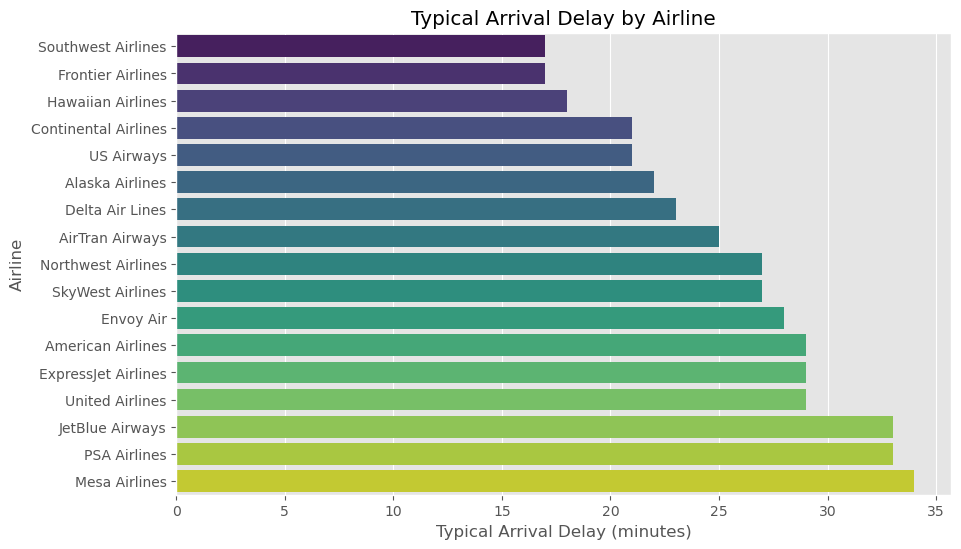

In [31]:
carrier_names = {
    'AA': 'American Airlines',
    'AS': 'Alaska Airlines',
    'B6': 'JetBlue Airways',
    'CO': 'Continental Airlines',
    'DL': 'Delta Air Lines',
    'EV': 'ExpressJet Airlines',
    'F9': 'Frontier Airlines',
    'FL': 'AirTran Airways',
    'HA': 'Hawaiian Airlines',
    'MQ': 'Envoy Air',
    'NW': 'Northwest Airlines',
    'OH': 'PSA Airlines',
    'OO': 'SkyWest Airlines',
    'UA': 'United Airlines',
    'US': 'US Airways',
    'WN': 'Southwest Airlines',
    'XE': 'ExpressJet Airlines',
    'YV': 'Mesa Airlines'
}

df['CarrierName'] = df['UniqueCarrier'].map(carrier_names)

# Calculate average delay per airline
airline_delay = df.groupby('CarrierName')['ArrDelay'].median().sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=airline_delay.values, y=airline_delay.index, palette='viridis')
plt.title('Typical Arrival Delay by Airline')
plt.xlabel('Typical Arrival Delay (minutes)')
plt.ylabel('Airline')
plt.show()


### 📌 Takeaways


The differences between airlines aren’t massive, but they’re noticeable. Some carriers consistently average shorter delays, while others show a higher average — which could reflect operational efficiency, airport hubs, route types, or even external constraints.

It’s worth keeping in mind that this doesn't tell the whole story — things like weather patterns, route length, and airport congestion could all influence these results. But it’s still a good first step to identify which carriers stand out (positively or negatively) when it comes to delays.


## 📅 Typical Arrival Delay by Day of the Week

Let’s check whether flight delays vary depending on the day of the week. It's pretty common to see spikes around weekends or Mondays, when both business and leisure travel peak.

The column `DayOfWeek` goes from 1 (Monday) to 7 (Sunday), so we’ll map those numbers to actual weekday names to make things more readable. Then, we’ll calculate the average delay for each day and visualize the results.


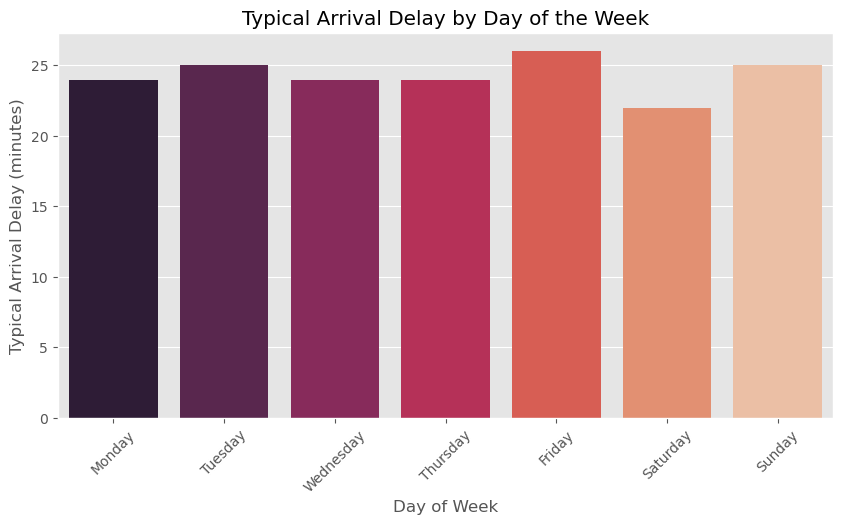

In [33]:
# Map numeric day to weekday name
weekday_map = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
    5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
df['DayName'] = df['DayOfWeek'].map(weekday_map)

# Group and sort by weekday (logical order)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mdn_delay_by_day = df.groupby('DayName')['ArrDelay'].median().reindex(weekday_order)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=mdn_delay_by_day.index, y=mdn_delay_by_day.values, palette='rocket')
plt.title('Typical Arrival Delay by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Typical Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


### 📌 Takeaways


There’s some variation across the week, though nothing too extreme. A few days — like Friday and Sunday — tend to show slightly higher average delays, which could reflect heavier passenger traffic, tighter schedules, or operational fatigue at the end of the week.

It’s also possible that weekend travel (often more leisure-oriented) is more vulnerable to cascading delays, while midweek operations run a bit more smoothly. These kinds of patterns are worth keeping in mind, especially if we’re thinking about delay prediction or resource planning down the line.


## 🛬 Typical Arrival Delay by Origin Airport

Next, I want to explore whether some airports are more likely to experience delays than others. It makes sense that origin airports might play a big role — depending on traffic, weather, or how tightly scheduled the departures are.

To keep things readable, I’ll limit the chart to the top 15 airports by volume. Then, I’ll look at the average delay from each one to see who’s performing better (or worse) when it comes to getting planes off the ground on time.


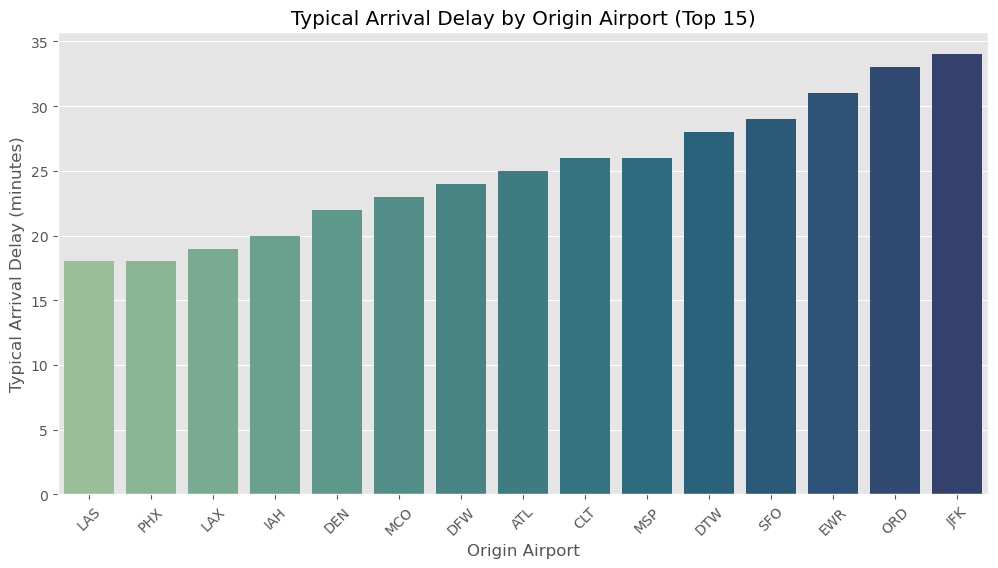

In [36]:
# Top 15 airports by number of flights
top_airports = df['Origin'].value_counts().head(15).index

# Calculate average delay for those airports
mdn_delay_airport = df[df['Origin'].isin(top_airports)].groupby('Origin')['ArrDelay'].median().sort_values()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=mdn_delay_airport.index, y=mdn_delay_airport.values, palette='crest')
plt.title('Typical Arrival Delay by Origin Airport (Top 15)')
plt.xlabel('Origin Airport')
plt.ylabel('Typical Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


### 📌 Takeaways


Some origin airports clearly stand out when it comes to delays. This could be influenced by weather patterns (e.g. snow or storms), high traffic volume, or airport layout and efficiency.

It’s also possible that flights from smaller or less busy airports experience fewer delays simply because there’s less congestion. Either way, this gives a solid starting point for identifying systemic issues tied to location.


## 🔥 Correlation Between Delay Causes

Now I want to explore whether the different types of delays (carrier, weather, NAS, etc.) are related to each other. Sometimes a single delay triggers a chain reaction — for example, a weather delay could lead to late aircraft, which causes the next flight to be delayed as well.

A correlation heatmap gives a quick overview of which delay types tend to occur together, and how strong those relationships are.


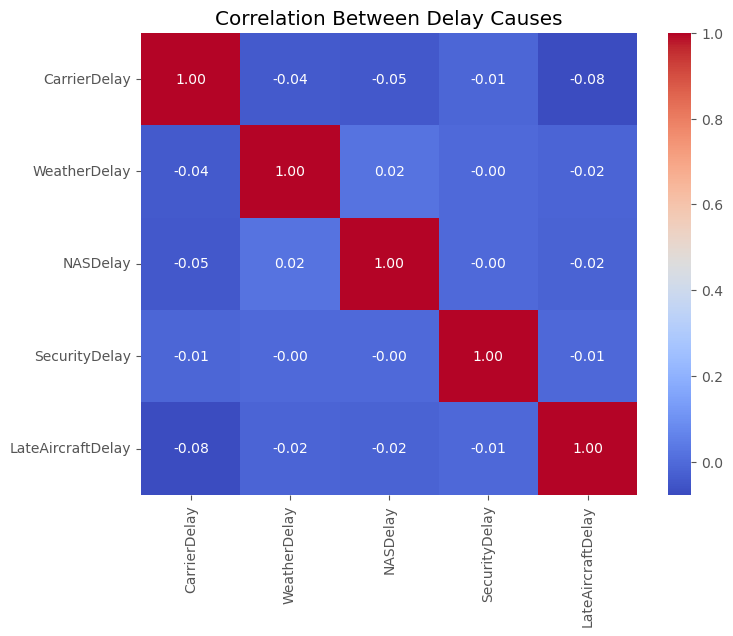

In [39]:
# Select only the delay-related columns
delay_columns = [
    'CarrierDelay', 'WeatherDelay', 'NASDelay',
    'SecurityDelay', 'LateAircraftDelay'
]

# Calculate correlation matrix
corr = df[delay_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Delay Causes')
plt.show()


### 🔍 Observations

Some delays seem to move together — especially weather delay and NAS delays, which makes sense given how one can easily trigger the other. Carrier and weather delays seem a bit more independent.

While correlation doesn't imply causation, this view helps spot clusters of related operational issues.


## 🧩 Categorizing Delay Severity

For modeling or storytelling purposes, it’s often useful to bucket delays into categories instead of using raw minutes. That lets us define thresholds like “minor delay”, “moderate delay”, and “severe delay”, which can be easier to interpret in charts or reports.
 

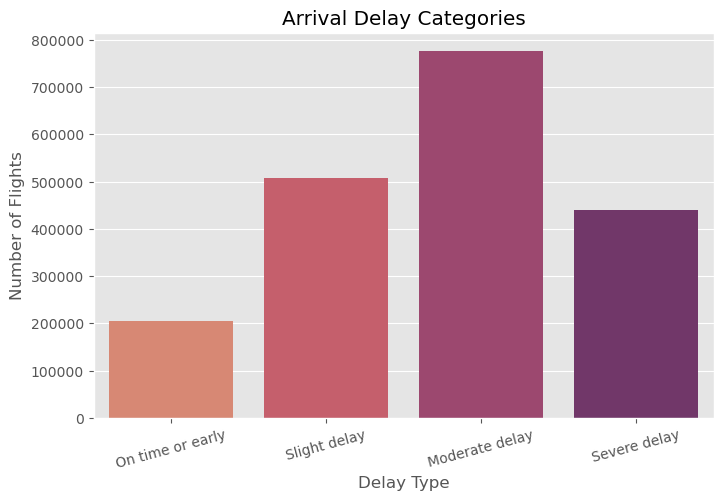

In [27]:
# Create a new categorical delay label
def classify_delay(minutes):
    if minutes <= 0:
        return 'On time or early'
    elif minutes <= 15:
        return 'Slight delay'
    elif minutes <= 60:
        return 'Moderate delay'
    else:
        return 'Severe delay'

df['DelayCategory'] = df['ArrDelay'].apply(classify_delay)

# Plot distribution of delay categories
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='DelayCategory', order=['On time or early', 'Slight delay', 'Moderate delay', 'Severe delay'], palette='flare')
plt.title('Arrival Delay Categories')
plt.xlabel('Delay Type')
plt.ylabel('Number of Flights')
plt.xticks(rotation=15)
plt.show()


### 🧠 Quick Thoughts

Most flights are either on time or just slightly delayed, but there’s still a significant number in the “severe” delay group. This kind of binning can be especially helpful later if I want to turn this into a classification task instead of a regression problem.


## 🕒 Delay Trends Over Time (Monthly)

Finally, let’s take a look at how delays evolve over the year. Are there particular months where delays spike? Maybe summer storms or holiday congestion play a role?

I’ll extract the month from the `Date` column and plot the average delay for each one.


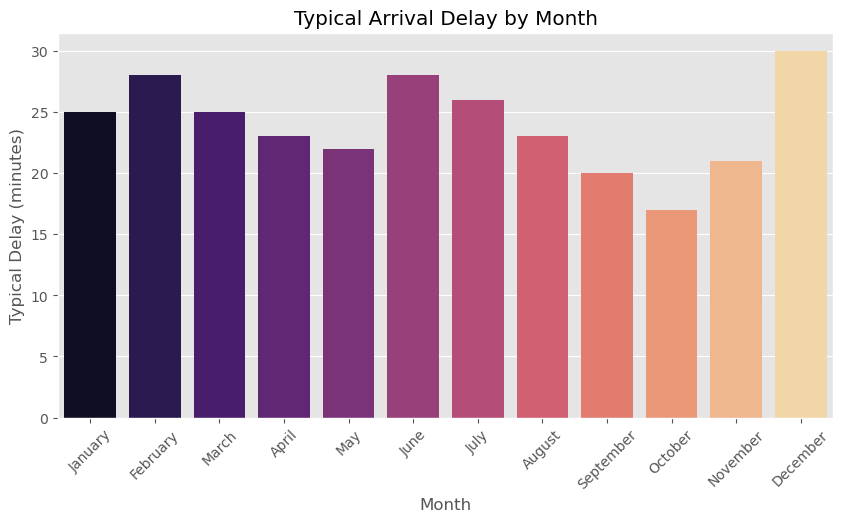

In [38]:
# Extract month name from Date
df['Month'] = df['Date'].dt.month_name()

# Order months chronologically
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Group and plot
monthly_mdn_delay = df.groupby('Month')['ArrDelay'].median().reindex(month_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_mdn_delay.index, y=monthly_mdn_delay.values, palette='magma')
plt.title('Typical Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Typical Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


### 🔍 Observations

Delays tend to rise in the summer months, which could be tied to thunderstorms or peak travel seasons. Some dips in the early months of the year might reflect lower passenger volume or fewer weather disruptions.

It’s interesting to see these patterns unfold — they could be useful for scheduling, staffing, or setting customer expectations.


## 📚 Summary of EDA Insights

This exploratory analysis revealed meaningful variation in delays across airlines, days of the week, and airports. We saw that delay causes like NAS and late aircraft are often correlated, and that most flights fall into the on-time or slightly delayed categories — but with a notable long tail of severe delays.

These patterns not only provide useful context for understanding airline punctuality, but also lay the groundwork for building a predictive model or interactive dashboard.
